# **Generating Simpson Faces**

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
# import imageio as Image
from PIL import Image
from torchvision.utils import make_grid
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
import matplotlib.image as mpimg
from skimage import io
from torchvision.utils import save_image
import sys
from tqdm import tqdm

In [ ]:
!wget https://www.dropbox.com/s/g0w7a3x1aw3oonf/SimpsonFaces.zip

!unzip SimpsonFaces.zip

!ls

流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: __MACOSX/cropped/._4084.png  
  inflating: cropped/3933.png        
  inflating: __MACOSX/cropped/._3933.png  
  inflating: cropped/2393.png        
  inflating: __MACOSX/cropped/._2393.png  
  inflating: cropped/1842.png        
  inflating: __MACOSX/cropped/._1842.png  
  inflating: cropped/4912.png        
  inflating: __MACOSX/cropped/._4912.png  
  inflating: cropped/326.png         
  inflating: __MACOSX/cropped/._326.png  
  inflating: cropped/440.png         
  inflating: __MACOSX/cropped/._440.png  
  inflating: cropped/9588.png        
  inflating: __MACOSX/cropped/._9588.png  
  inflating: cropped/8696.png        
  inflating: __MACOSX/cropped/._8696.png  
  inflating: cropped/6863.png        
  inflating: __MACOSX/cropped/._6863.png  
  inflating: cropped/454.png         
  inflating: __MACOSX/cropped/._454.png  
  inflating: cropped/8682.png        
  inflating: __MACOSX/cropped/._8682.png  
  inflating: cropped/6877.png        
  in

## Dataloader
####  Write a dataloader to read images from the folder 'faces/' (Note that the transform *trans* resizes the images to 32x32)

In [ ]:
trans = transforms.Compose([transforms.ToTensor(),transforms.Resize([32,32])])

# Replace the question marks '?' by the necessary code
batch_size = 64

class MyDataset(Dataset):
  def __init__(self, image_path, transform = trans):
    self.image_path = image_path
    self.images = os.listdir(image_path)
    self.transform = transform

  def __len__(self):
    return len(self.images)

  def __getitem__(self,idx):
    path = os.path.join(self.image_path, self.images[idx])
    im = Image.open(path)
    im = self.transform(im)
    return im

In [ ]:
dataset = MyDataset("cropped/")

train_loader = DataLoader(dataset, batch_size = batch_size)

In [ ]:
print(train_loader.dataset.images)

['8189.png', '164.png', '6531.png', '8555.png', '5693.png', '1586.png', '6897.png', '161.png', '4818.png', '9148.png', '7672.png', '696.png', '3254.png', '512.png', '1363.png', '4960.png', '8917.png', '1694.png', '2.png', '568.png', '9036.png', '784.png', '5980.png', '5462.png', '1994.png', '2083.png', '3739.png', '4686.png', '3048.png', '7384.png', '3647.png', '3309.png', '6672.png', '1330.png', '1505.png', '3545.png', '8481.png', '1807.png', '8861.png', '7633.png', '6502.png', '5988.png', '4361.png', '2233.png', '159.png', '2604.png', '6361.png', '5265.png', '7197.png', '7800.png', '6182.png', '6000.png', '5301.png', '6983.png', '4288.png', '7611.png', '8679.png', '2249.png', '6422.png', '352.png', '7707.png', '2386.png', '7886.png', '6740.png', '4029.png', '1383.png', '9630.png', '7894.png', '1826.png', '2582.png', '7692.png', '9783.png', '1259.png', '1512.png', '1629.png', '959.png', '8335.png', '3475.png', '871.png', '1912.png', '4344.png', '8649.png', '2568.png', '1469.png', '802

#### Visualize the data
##### Get a batch from the dataloader and visualize its images

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


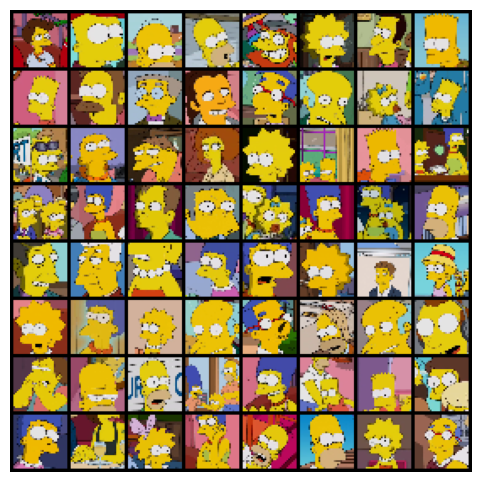

In [ ]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

data_iter = iter(train_loader)
images_batch = next(data_iter)

# Visualize the batch of images
def visualize(batch):
  batch = vutils.make_grid(batch, nrow=8, padding=2, normalize=True)
  img = batch.numpy()
  plt.figure(figsize=(20, 6))
  plt.imshow(np.transpose(img, (1, 2, 0)))
  plt.axis('off')
  plt.show()

visualize(images_batch)

### Generative Model class
#### Write a Generative Model class in the following cell

In [ ]:
class VAE(nn.Module):
    def __init__(self, zsize):
        super(VAE, self).__init__()

        self.zsize = zsize

        # Encoder
        self.conv1 = nn.Conv2d(3, 128, 4, 2, 1) # The kernel size is 4 in order to fit the shape of the image (128*128), each time the width and height will be cut in half.
        self.conv1_bn = nn.BatchNorm2d(128)
        self.conv2 = nn.Conv2d(128, 256, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(256)
        self.conv3 = nn.Conv2d(256, 512, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(512)
        self.conv4 = nn.Conv2d(512, 1024, 4, 2, 1)
        self.conv4_bn = nn.BatchNorm2d(1024)
        self.conv5 = nn.Conv2d(1024, 2048, 4, 2, 1)
        self.conv5_bn = nn.BatchNorm2d(2048)

        self.fc1 = nn.Linear(2048 * 4 * 4, zsize) # Fully Connected Layer
        self.fc2 = nn.Linear(2048 * 4 * 4, zsize)

        # Decoder
        self.d1 = nn.Linear(zsize, 2048 * 4 * 4)
        self.deconv1 = nn.ConvTranspose2d(2048, 1024, 4, 2, 1)
        self.deconv1_bn = nn.BatchNorm2d(1024)
        self.deconv2 = nn.ConvTranspose2d(1024, 512, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(512)
        self.deconv3 = nn.ConvTranspose2d(512, 256, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(256)
        self.deconv4 = nn.ConvTranspose2d(256, 128, 4, 2, 1)
        self.deconv4_bn = nn.BatchNorm2d(128)
        self.deconv5 = nn.ConvTranspose2d(128, 3, 4, 2, 1)

    def encode(self, x):
        x = F.relu(self.conv1_bn(self.conv1(x)))
        x = F.relu(self.conv2_bn(self.conv2(x)))
        x = F.relu(self.conv3_bn(self.conv3(x)))
        x = F.relu(self.conv4_bn(self.conv4(x)))
        x = F.relu(self.conv5_bn(self.conv5(x)))
        x = x.view(x.shape[0], 2048 * 4 * 4)
        h1 = self.fc1(x)
        h2 = self.fc2(x)
        return h1, h2

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, x):
        x = x.view(x.shape[0], self.zsize)
        x = self.d1(x)
        x = x.view(x.shape[0], 2048, 4, 4)
        x = F.leaky_relu(x, 0.2)
        x = F.leaky_relu(self.deconv1_bn(self.deconv1(x)), 0.2)
        x = F.leaky_relu(self.deconv2_bn(self.deconv2(x)), 0.2)
        x = F.leaky_relu(self.deconv3_bn(self.deconv3(x)), 0.2)
        x = F.leaky_relu(self.deconv4_bn(self.deconv4(x)), 0.2)
        x = torch.tanh(self.deconv5(x))
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        mu = mu.squeeze()
        logvar = logvar.squeeze()
        z = self.reparameterize(mu, logvar)
        return self.decode(z.view(-1, self.zsize, 1, 1)), mu, logvar

    def weight_init(self, mean, std):
        for m in self.modules():
            if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
                m.weight.data.normal_(mean, std)
                m.bias.data.zero_()

## Loss
#### Define Loss function in the following cell
### KL Divergence
$D_{KL}{(p||q)} = \sum\limits_{i=1}^{N} p(x_i)(log(\frac{p(x_i)}{q(x_i)}))$

### Loss function
$L = min((||x - \hat{x}||^2) - \frac{1}{2} (log\sigma ^2 + 1 - \mu^2 - \sigma^2))$

In [ ]:
def loss_function(recon_x, x, mu, logvar):
    mse = torch.mean((recon_x - x) ** 2)
    kld = -0.5 * torch.mean(torch.mean(1 + logvar - mu.pow(2) - logvar.exp(), 1)) # One dimension for the result
    return mse, kld * kl_weight

In [ ]:
def process_images(image_collection):
    data = [np.array(Image.fromarray(x).resize([im_size, im_size])).transpose((2, 0, 1)) for x in image_collection]
    x = np.asarray(data, dtype=np.float32) / 127.5 - 1. # Normalization, the value is within [-1, 1]
    x = x.reshape(-1, 3, im_size, im_size) # Reshape the images
    return x

## Hyperparameters
- Images' sizes are set to be 128 instead of 32. As shown above, if it only has 32*32, much information is lost and we cannot even see the eyes of Simpsons.
- Batch size is set to be 64
- Latent (Z) size is set to be 512
- Train epoch is set to be 30 deal to the limitation of training time


In [ ]:
im_size = 128
batch_size = 64
z_size = 512
kl_weight = 1.7
train_epoch = 50
lr = 0.0008
gradient_clipping_value = 0.1

## Preparing Dataset
Unfortunately, I have not figured out how to use the MyDataset to fit in the model. The items seem exactly the same and also the outputs are the same. But it is not working. Reluctantly, I still use the usual way to create the data loader.

In [ ]:
import math
im_collection = io.imread_collection('./cropped/*.png')
data_train = images = process_images(im_collection)
print("Training dataset size:", len(data_train))
batches_per_epoch = (math.ceil(len(data_train) / batch_size))
print("Batches per epoch: ", batches_per_epoch)
os.makedirs('results_reconstructed', exist_ok=True)
os.makedirs('results_generated', exist_ok=True)
train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, shuffle=True)

Training dataset size: 9877
Batches per epoch:  155


## Training the model

In [ ]:
from torch.nn.modules.loss import KLDivLoss
vae = VAE(zsize=z_size)
vae.cuda()
vae.train()
vae.weight_init(mean=0, std=0.02)
vae_optimizer = optim.Adam(vae.parameters(), lr=lr)

reconstruction_loss_list = []
KL_loss_list = []

for epoch in range(train_epoch):
    vae.train()
    reconstruction_loss = 0
    kullback_leibler_loss = 0
    i = 0
    training_pbar = tqdm(total=len(data_train),
                         position=0, leave=True,
                         file=sys.stdout, bar_format="{l_bar}{bar:70}{r_bar}")
    for _, x in enumerate(train_loader):
        # ============================================ TRAINING ========================================================
        vae.train()
        vae.zero_grad()
        x = x.cuda()
        rec, mu, logvar = vae(x)
        loss_re, loss_kl = loss_function(rec, x, mu, logvar)
        (loss_re + loss_kl).backward()
        torch.nn.utils.clip_grad_norm_(vae.parameters(), gradient_clipping_value)
        vae_optimizer.step()
        reconstruction_loss += loss_re.item()
        kullback_leibler_loss += loss_kl.item()
        training_pbar.update(x.shape[0])
        # ============================================ VALIDATION ======================================================
        i += 1
        if i % batches_per_epoch == 0:
            training_pbar.close()
            print('\nEpoch [%d/%d] - reconstruction loss: %.9f, Kullback-Leibler loss: %.9f' % (
                (epoch + 1), train_epoch, reconstruction_loss / batches_per_epoch,
                kullback_leibler_loss / batches_per_epoch))

            reconstruction_loss_list.append(reconstruction_loss)
            KL_loss_list.append(kullback_leibler_loss)

            reconstruction_loss = 0
            kullback_leibler_loss = 0
            with torch.no_grad():
                vae.eval()
                x_rec, _, _ = vae(x)
                result_sampled = torch.cat([x, x_rec]) * 0.5 + 0.5
                result_sampled = result_sampled.cpu()
                save_image(result_sampled.view(-1, 3, im_size, im_size),
                           'results_reconstructed/sample_' + str(epoch) + '.png')
                sample = torch.randn(128, z_size).view(-1, z_size, 1, 1).cuda()
                x_rec = vae.decode(sample)
                result_sampled = x_rec * 0.5 + 0.5
                result_sampled = result_sampled.cpu()
                save_image(result_sampled.view(-1, 3, im_size, im_size),
                           'results_generated/sample_' + str(epoch) + '.png')
torch.save(vae.state_dict(), "./weights_" + str(epoch) + ".pth")

100%|██████████████████████████████████████████████████████████████████████| 9877/9877 [01:46<00:00, 93.11it/s]

Epoch [1/50] - reconstruction loss: 0.268775693, Kullback-Leibler loss: 67.126607615
100%|██████████████████████████████████████████████████████████████████████| 9877/9877 [01:54<00:00, 86.43it/s]

Epoch [2/50] - reconstruction loss: 0.233861450, Kullback-Leibler loss: 0.104842728
100%|██████████████████████████████████████████████████████████████████████| 9877/9877 [01:59<00:00, 82.94it/s]

Epoch [3/50] - reconstruction loss: 0.206292368, Kullback-Leibler loss: 0.018812101
100%|██████████████████████████████████████████████████████████████████████| 9877/9877 [01:59<00:00, 82.94it/s]

Epoch [4/50] - reconstruction loss: 0.192503752, Kullback-Leibler loss: 0.020930052
100%|██████████████████████████████████████████████████████████████████████| 9877/9877 [01:58<00:00, 83.05it/s]

Epoch [5/50] - reconstruction loss: 0.187677410, Kullback-Leibler loss: 0.022148131
100%|█████████

*Gradient Clipping*
![Gradient Clipping](https://img-blog.csdnimg.cn/20201214160709112.png?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L3FxXzM0NzY5MTYy,size_16,color_FFFFFF,t_70)

### Visualize Loss plot

Using the arrays that are recorded in the previous operation

Visualize the loss plot (train and validation together)

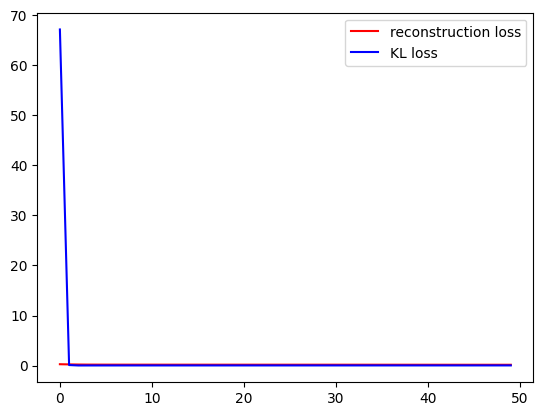

In [ ]:
x = list(range(train_epoch))
rl = []
kl = []
for i in range(train_epoch):
  rl.append(reconstruction_loss_list[i]/batches_per_epoch)
  kl.append(KL_loss_list[i]/batches_per_epoch)
plt.plot(x, rl, 'r')
plt.plot(x, kl, 'b')
plt.legend(['reconstruction loss', 'KL loss'])
plt.show()

## Testing

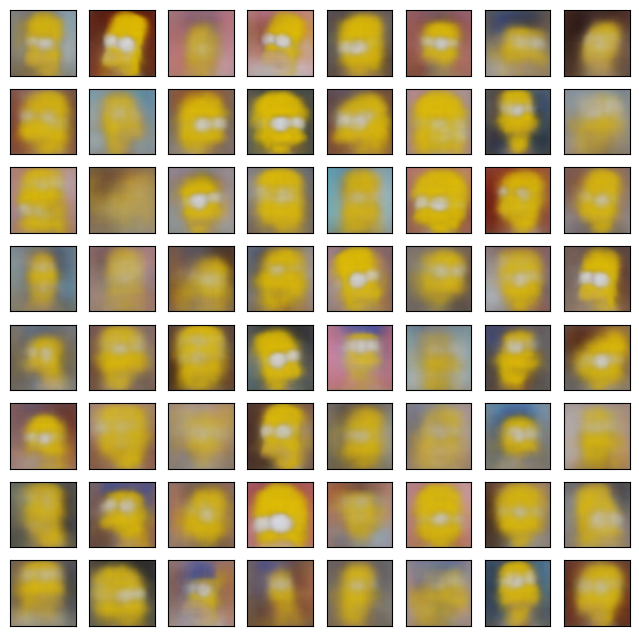

In [ ]:
vae.load_state_dict(torch.load("./weights_49.pth")) # The name of file needs to be changed according to the number of epochs
os.makedirs('generated_results', exist_ok=True)
for i in range(0, 1):
    sample = torch.randn(64, z_size).view(-1, z_size, 1, 1).cuda()
    x_rec = vae.decode(sample)
    result_sampled = x_rec * 0.5 + 0.5
    result_sampled = result_sampled.cpu()
    _, axes = plt.subplots(nrows=8, ncols=8, figsize=(8, 8))

    counter = 0
    for i in range(8):
      for j in range(8):
        axes[i][j].imshow(result_sampled.detach()[counter].permute(1, 2, 0).numpy())
        axes[i][j].set_xticks([])
        axes[i][j].set_yticks([])
        counter += 1
    plt.show
    # save_image(result_sampled.view(-1, 3, im_size, im_size), 'generated_results/sample_' + str(i) + '.png')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
